In [1]:
import numpy as np
import os

from osgeo import gdal
# os.environ['PROJ_LIB'] = r'C:\Users\Lenovo\.conda\envs\zph\Library\share\proj'
# os.environ['GDAL_DATA'] = r'C:\Users\Lenovo\.conda\envs\zph\Library\share'
# gdal.PushErrorHandler("CPLQuietErrorHandler")

class ImageProcess:
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.dataset = gdal.Open(self.filepath, gdal.GA_ReadOnly)
        if not self.dataset:
            raise Exception(f"Failed to open file: {filepath}")
        self.info = []
        self.img_data = None
        self.data_8bit = None

    def read_img_info(self):
        # get basic information about the band
        img_bands = self.dataset.RasterCount
        img_width = self.dataset.RasterXSize
        img_height = self.dataset.RasterYSize
        # Get affine matrix and projection
        img_geotrans = self.dataset.GetGeoTransform()
        img_proj = self.dataset.GetProjection()
        self.info = [img_bands, img_width, img_height, img_geotrans, img_proj]
        return self.info

    # def read_img_data(self):
    #     self.img_data = self.dataset.ReadAsArray(0, 0, self.info[1], self.info[2])
    #     # Check if self.img_data is a NumPy array
    #     if not isinstance(self.img_data, np.ndarray):
    #         print("Not a correct format (not a NumPy array)")
    #     else:
    #         return self.img_data
    def read_img_data(self):
        if not self.info:  # Ensure read_img_info has been called
            raise Exception("Image info not available. Call read_img_info() first.")
        
        # Check if image width and height were retrieved correctly
        img_width = self.info[1]
        img_height = self.info[2]

        if not isinstance(img_width, int) or not isinstance(img_height, int):
            raise TypeError("Width and height must be integers.")

        self.img_data = self.dataset.ReadAsArray(0, 0, img_width, img_height)
        
        # Check if self.img_data is a NumPy array
        if not isinstance(self.img_data, np.ndarray):
            raise TypeError("Not a correct format (not a NumPy array)")
        
        return self.img_data

    # Write the image to a file
    @staticmethod
    def write_img(filename: str, img_data: np.array, **kwargs):
        # Determine the data type of the raster data
        if 'int8' in img_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in img_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32
        # Determine the number of dimensions in the array
        if len(img_data.shape) >= 3:
            img_bands, img_height, img_width = img_data.shape
        else:
            img_bands, (img_height, img_width) = 1, img_data.shape
        # Create the file
        driver = gdal.GetDriverByName("GTiff")
        outdataset = driver.Create(filename, img_width, img_height, img_bands, datatype)
        # Write affine transformation parameters
        if 'img_geotrans' in kwargs:
            outdataset.SetGeoTransform(kwargs['img_geotrans'])
        # Write projection
        if 'img_proj' in kwargs:
            outdataset.SetProjection(kwargs['img_proj'])
        # Write the file
        if img_bands == 1:
            outdataset.GetRasterBand(1).WriteArray(img_data)  # Write array data
        else:
            for i in range(img_bands):
                outdataset.GetRasterBand(i + 1).WriteArray(img_data[i])

        del outdataset

In [2]:
def read_multi_bands(image_path):
    """
    Read multi-band file
    :param image_path: Path to the multi-band file
    :return: Image object, image metadata, image matrix
    """
    # Image reading
    image = ImageProcess(filepath=image_path)
    # Read image metadata
    image_info = image.read_img_info()
    print(f"Multi-band image metadata: {image_info}")
    # Read image matrix
    image_data = image.read_img_data()
    print(f"Multi-band matrix size: {image_data.shape}")
    return image, image_info, image_data




In [3]:
# Single band images
def read_single_band(band_path):
    """
    Read single-band file
    :param band_path: Path to the single-band file
    :return: Image object, image metadata, image matrix
    """
    # Image reading
    band = ImageProcess(filepath=band_path)
    # Read image metadata
    band_info = band.read_img_info()
    print(f"Single-band image metadata: {band_info}")
    # Read image matrix
    band_data = band.read_img_data()
    print(f"Single-band matrix size: {band_data.shape}")
    return band, band_info, band_data


import math
import numpy as np
from alive_progress import alive_bar


def cal_single_band_slice(single_band_data, slice_size=512):
    """
    Calculate the grid clipping corner points for a single-band image
    :param single_band_data: Original single-band data
    :param slice_size: Clip size
    :return: Nested list of corner row and column numbers for each block
    """
    single_band_size = single_band_data.shape
    row_num = math.ceil(single_band_size[0] / slice_size)  # Round up
    col_num = math.ceil(single_band_size[1] / slice_size)  # Round up
    print(f"Image size: {single_band_size}, Number of row splits: {row_num}, Number of column splits: {col_num}")
    slice_index = []
    for i in range(row_num):
        for j in range(col_num):
            row_min = i * slice_size
            row_max = (i + 1) * slice_size
            if (i + 1) * slice_size > single_band_size[0]:
                row_max = single_band_size[0]
            col_min = j * slice_size
            col_max = (j + 1) * slice_size
            if (j + 1) * slice_size > single_band_size[1]:
                col_max = single_band_size[1]
            slice_index.append([row_min, row_max, col_min, col_max])
    return slice_index


def single_band_slice(single_band_data, index=[0, 1000, 0, 1000], slice_size=1000, edge_fill=False):
    """
    Slice the single-band image based on corner coordinates
    :param single_band_data: Original matrix data
    :param index: Corner coordinates
    :param slice_size: Block size
    :param edge_fill: Whether to perform edge filling
    :return: Sliced single-band matrix
    """
    if edge_fill:
        if (index[1] - index[0] != slice_size) or (index[3] - index[2] != slice_size):
            result = np.empty(shape=(slice_size, slice_size))
            new_row_min = index[0] % slice_size
            new_row_max = new_row_min + (index[1] - index[0])
            new_col_min = index[2] % slice_size
            new_col_max = new_col_min + (index[3] - index[2])
            result[new_row_min:new_row_max, new_col_min:new_col_max] = single_band_data[index[0]:index[1],
                                                                       index[2]:index[3]]
        else:
            result = single_band_data[index[0]:index[1], index[2]:index[3]]
    else:
        result = single_band_data[index[0]:index[1], index[2]:index[3]]
    return result.astype(single_band_data.dtype)


def slice_conbine(slice_all, slice_index):
    """
    Combine block matrices
    :param slice_all: List of all block matrices
    :param slice_index: Block corner coordinates
    :return: Combined matrix
    """
    combine_data = np.zeros(shape=(slice_index[-1][1], slice_index[-1][3]))
    # print(combine_data.shape)
    for i, slice_element in enumerate(slice_index):
        combine_data[slice_element[0]:slice_element[1], slice_element[2]:slice_element[3]] = slice_all[i]
    return combine_data


def coordtransf(Xpixel, Ypixel, GeoTransform):
    """
    Affine transformation between pixel and geographic coordinates
    :param Xpixel: Row number of the upper left corner
    :param Ypixel: Column number of the upper left corner
    :param GeoTransform: Original affine matrix
    :return: New affine matrix
    """
    XGeo = GeoTransform[0] + GeoTransform[1] * Xpixel + Ypixel * GeoTransform[2]
    YGeo = GeoTransform[3] + GeoTransform[4] * Xpixel + Ypixel * GeoTransform[5]
    slice_geotrans = (XGeo, GeoTransform[1], GeoTransform[2], YGeo, GeoTransform[4], GeoTransform[5])
    return slice_geotrans


def single_band_grid_slice(band_path, band_slice_dir, slice_size, edge_fill=False):
    """
    Single-band grid slicing
    :param band_path: Original single-band image
    :param band_slice_dir: Directory to save the clipped files
    :param slice_size: Clip size
    :return:
    """
    band, band_info, band_data = read_single_band(band_path)
    # Calculate corner row and column numbers for each block
    slice_index = cal_single_band_slice(band_data, slice_size=slice_size)
    # Perform slicing
    with alive_bar(len(slice_index), force_tty=True) as bar:
        for i, slice_element in enumerate(slice_index):
            slice_data = single_band_slice(band_data, index=slice_element, slice_size=slice_size,
                                           edge_fill=edge_fill)  # Slice the single-band image
            slice_geotrans = coordtransf(slice_element[2], slice_element[0], band_info[3])  # Transform affine coordinates
            band.write_img(band_slice_dir + r'\single_grid_slice_' + str(i) + '.tif', slice_data,
                           img_geotrans=slice_geotrans, img_proj=band_info[4])  # Write to file
            bar()
        print('Single-band grid slicing completed')


In [4]:
# Multi-band images
def read_multi_bands(image_path):
    """
    Read multi-band file
    :param image_path: Path to the multi-band file
    :return: Image object, image metadata, image matrix
    """
    # Image reading
    image = ImageProcess(filepath=image_path)
    # Read image metadata
    image_info = image.read_img_info()
    print(f"Multi-band image metadata: {image_info}")
    # Read image matrix
    image_data = image.read_img_data()
    print(f"Multi-band matrix size: {image_data.shape}")
    return image, image_info, image_data


import math
import numpy as np
from alive_progress import alive_bar

def cal_single_band_slice(single_band_data, slice_size=512):
    """
    Calculate the grid clipping corner points for a single-band image
    :param single_band_data: Original single-band data
    :param slice_size: Clip size
    :return: Nested list of corner row and column numbers for each block
    """
    single_band_size = single_band_data.shape
    row_num = math.ceil(single_band_size[0] / slice_size)  # Round up
    col_num = math.ceil(single_band_size[1] / slice_size)  # Round up
    print(f"Image size: {single_band_size}, Number of row splits: {row_num}, Number of column splits: {col_num}")
    slice_index = []
    for i in range(row_num):
        for j in range(col_num):
            row_min = i * slice_size
            row_max = (i + 1) * slice_size
            if (i + 1) * slice_size > single_band_size[0]:
                row_max = single_band_size[0]
            col_min = j * slice_size
            col_max = (j + 1) * slice_size
            if (j + 1) * slice_size > single_band_size[1]:
                col_max = single_band_size[1]
            slice_index.append([row_min, row_max, col_min, col_max])
    return slice_index


def multi_bands_slice(multi_bands_data, index=[0, 512, 0, 512], slice_size=512, edge_fill=False):
    """
    Slice the multi-band image based on corner coordinates
    :param multi_bands_data: Original multi-band matrix
    :param index: Corner coordinates
    :param slice_size: Block size
    :param edge_fill: Whether to perform edge filling
    :return: Sliced multi-band matrix
    """
    if edge_fill == True:
        if (index[1] - index[0] != slice_size) or (index[3] - index[2] != slice_size):
            result = np.empty(shape=(multi_bands_data.shape[0], slice_size, slice_size))
            new_row_min = index[0] % slice_size    # 0
            new_row_max = new_row_min + (index[1] - index[0])  
            new_col_min = index[2] % slice_size    # 0
            new_col_max = new_col_min + (index[3] - index[2])
            result[:, new_row_min:new_row_max, new_col_min:new_col_max] = multi_bands_data[:, index[0]:index[1],
                                                                          index[2]:index[3]]
        else:
            result = multi_bands_data[:, index[0]:index[1], index[2]:index[3]] 
    else:
        result = multi_bands_data[:, index[0]:index[1], index[2]:index[3]]
    return result.astype(multi_bands_data.dtype)


def slice_conbine(slice_all, slice_index):
    """
    Combine block matrices
    :param slice_all: List of all block matrices
    :param slice_index: Block corner coordinates
    :return: Combined matrix
    """
    combine_data = np.zeros(shape=(slice_index[-1][1], slice_index[-1][3]))
    # print(combine_data.shape)
    for i, slice_element in enumerate(slice_index):
        combine_data[slice_element[0]:slice_element[1], slice_element[2]:slice_element[3]] = slice_all[i]
    return combine_data


def coordtransf(Xpixel, Ypixel, GeoTransform):
    """
    Affine transformation between pixel and geographic coordinates
    :param Xpixel: Row number of the upper left corner
    :param Ypixel: Column number of the upper left corner
    :param GeoTransform: Original affine matrix
    :return: New affine matrix
    """
    XGeo = GeoTransform[0] + GeoTransform[1] * Xpixel + Ypixel * GeoTransform[2]
    YGeo = GeoTransform[3] + GeoTransform[4] * Xpixel + Ypixel * GeoTransform[5]
    slice_geotrans = (XGeo, GeoTransform[1], GeoTransform[2], YGeo, GeoTransform[4], GeoTransform[5])
    return slice_geotrans


def multi_bands_grid_slice(image_path, image_slice_dir, slice_size, edge_fill=False):
    """
    Multi-band grid slicing
    :param image_path: Original multi-band image
    :param image_slice_dir: Directory to save the clipped files
    :param slice_size: Clip size
    :return:
    """
    image, image_info, image_data = read_multi_bands(image_path)

    # Calculate corner row and column numbers for each block
    slice_index = cal_single_band_slice(image_data[0, :, :], slice_size=slice_size)
    # Perform slicing
    with alive_bar(len(slice_index), force_tty=True) as bar:
        for i, slice_element in enumerate(slice_index):
            slice_data = multi_bands_slice(image_data, index=slice_element, slice_size=slice_size,
                                           edge_fill=edge_fill)  # Slice the multi-band image
            slice_geotrans = coordtransf(slice_element[2], slice_element[0], image_info[3])  # Transform affine coordinates
            image.write_img(image_slice_dir + r'\multi_grid_slice_' + str(i) + '.tif', slice_data,
                            img_geotrans=slice_geotrans, img_proj=image_info[4])  # Write to file
            bar()
        print('Multi-band grid slicing completed')


In [5]:
# Create trainning folder with imgs folder and labels folder
root = "raw_material"

folder1 = os.path.join(root, 'dataset')
if not os.path.exists(folder1): os.mkdir(folder1)
foldertraining = os.path.join(folder1, 'trainning')
if not os.path.exists(foldertraining): os.mkdir(foldertraining)

train_img_folder = os.path.join(foldertraining, 'imgs')
if not os.path.exists(train_img_folder): os.mkdir(train_img_folder)

train_label_folder = os.path.join(foldertraining, 'labels')
if not os.path.exists(train_label_folder): os.mkdir(train_label_folder)

In [6]:
# Call the function multi_bands_grid_slice and single_band_grid_slice above
image_path = "raw_material\\naip.tif"
image_slice_dir = train_img_folder   
slice_size = 512
edge_fill = True
slice_train = multi_bands_grid_slice(image_path, image_slice_dir, slice_size, edge_fill=edge_fill)

label_path = "raw_material\\landuse.tif"
image_slice_dir = train_label_folder
slice_size = 512
edge_fill = True
slice_label= single_band_grid_slice(label_path, image_slice_dir, slice_size, edge_fill=edge_fill)    #single image here is label

d:\Miniconda\envs\DL\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Multi-band image metadata: [3, 5079, 5079, (2710573.1336033433, 1.9692670323847825, 0.0, 264944.4413223281, 0.0, -1.9692670323847825), 'PROJCS["NAD83 / Pennsylvania South (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",39.3333333333333],PARAMETER["central_meridian",-77.75],PARAMETER["standard_parallel_1",40.9666666666667],PARAMETER["standard_parallel_2",39.9333333333333],PARAMETER["false_easting",1968500],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]']
Multi-band matrix size: (3, 5079, 5079)
Image size: (5079, 5079), Number of row splits: 10, Number of column splits: 10
on 100: Multi-band grid slicing completed 

In [8]:
# Create validation folder with imgs and labels
import os 
valid_folder = os.path.join(folder1, 'validation')
if not os.path.exists(valid_folder): os.mkdir(valid_folder)
valid_label_folder = os.path.join(valid_folder, 'labels')
if not os.path.exists(valid_label_folder): os.mkdir(valid_label_folder)
valid_img_folder = os.path.join(valid_folder, 'imgs')
if not os.path.exists(valid_img_folder): os.mkdir(valid_img_folder)


In [9]:
# divide training folder and put 1/10 into validation folder 
import random
import shutil
import os
from pathlib import Path 

def split_train_validate(training_img_dir, training_labels_dir, validation_img_dir, validation_labels_dir, split=10):
    '''Split the training dataset into training and validation parts by randomly
    selecting 10% of the training dataset (images and labels) into the validation folder.
    '''
    # Get all images and labels in the training folder
    img_files = list(Path(training_img_dir).iterdir())
    label_files = list(Path(training_labels_dir).iterdir())

    # Make sure the number of images and labels is the same
    assert len(img_files) == len(label_files), "Number of images and labels do not match"

    # Get a set of random numbers for file moving in the for loop
    sample_size = len(img_files) // split
    sample_indices = random.sample(range(len(img_files)), sample_size)

    # Moving files
    for idx in sample_indices:
        img_file = img_files[idx]
        label_file = label_files[idx]
        shutil.move(str(img_file), os.path.join(validation_img_dir, img_file.name))
        shutil.move(str(label_file), os.path.join(validation_labels_dir, label_file.name))
    
    list(Path(training_img_dir).iterdir())


# Split train/validation
split_train_validate(train_img_folder, train_label_folder, valid_img_folder, valid_label_folder)


{'image': WindowsPath('raw_material/dataset/trainning/imgs/multi_grid_slice_0.tif'), 'mask': WindowsPath('raw_material/dataset/trainning/labels/single_grid_slice_0.tif')}
2


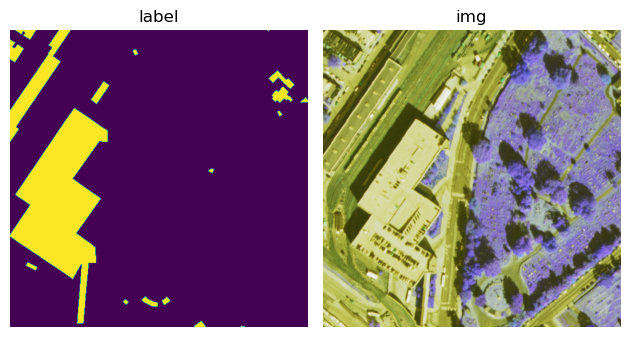

train_dl is: 14
<class 'torch.utils.data.dataloader.DataLoader'>
valid_dl is: 2
test_dl is: 2


In [10]:
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
from pathlib import Path
import matplotlib.pyplot as plt


# image augmentation
transform_aug = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-90, 90)),
     transforms.RandomVerticalFlip(p=0.5)
])

# Transfer pixel value to 0-1, implement image augmentation, creating dict to hold {img:lab}
class CanopyDataset(Dataset):
    def __init__(self, img_dir, msk_dir, pytorch=True, transforms=None):
        super().__init__()
        
        img_files = [f for f in img_dir.iterdir() if not f.is_dir()]
        mask_files = [f for f in msk_dir.iterdir() if not f.is_dir()]

        self.files = [self.combine_files(img, mask) for img, mask in zip(img_files, mask_files)]
        self.pytorch = pytorch
        self.transforms = transforms

    def combine_files(self, img_file: Path, mask_file: Path):
        files = {'image': img_file, 'mask': mask_file}
        return files
    
    def __len__(self):
        return len(self.files)
    
    def open_as_array(self, idx):
        image_path = str(self.files[idx]['image'])
        image = cv2.imread(image_path)

        image = cv2.resize(image, (512, 512))
        image = image.transpose((2, 0, 1)) / 255.0
        
        return image
    
    def open_mask(self, idx, add_dims=False):
        mask_path = str(self.files[idx]['mask'])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image = cv2.imread(mask_path)
        if image is None:
            raise ValueError(f"Image at {mask_path} could not be loaded.")
        mask = cv2.resize(mask, (512, 512))
        mask = np.where(mask == 5, 1, 0)   # Pixels with value 5 represent building pixels, this line of code regulates what the model should segment
        
        if add_dims:
            mask = np.expand_dims(mask, 0)
        
        return mask

    def __getitem__(self, idx):
        image = self.open_as_array(idx)
        mask = self.open_mask(idx, add_dims=False)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.int64)
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())
        return s
    


base_path = Path('raw_material//dataset//trainning')
data = CanopyDataset(base_path/'imgs', base_path/'labels')
print(data.files[0])


def check(data):
    sample = data[6]
    print(len(sample))
    img = sample[0]
    label = sample[1]
    sample = label.numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img.numpy()
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Display the first image in the first subplot
    axes[0].imshow(label)
    axes[0].set_title('label')
    axes[0].axis('off')

    # Display the second image in the second subplot
    axes[1].imshow(img)
    axes[1].set_title('img')
    axes[1].axis('off')

    # Adjust the layout to avoid overlapping images
    plt.tight_layout()

    # Show the figure
    plt.show()



try:
    check(data)
except ValueError as e:
    print(e)

len(data)
train_ds, valid_ds, test_ds = random_split(data, (70, 10, 10))
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=5, shuffle=True)

print('train_dl is:', len(train_dl))
print(type(train_dl))
print('valid_dl is:', len(valid_dl))
print('test_dl is:', len(test_dl))


In [11]:
import torch.nn as nn
import torch
import numpy as np


class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        #parameters: in_channels, out_channels, kernel_size, padding
        self.conv1 = self.encoder(in_channels, 64, 3, 1)
        self.conv2 = self.encoder(64, 128, 3, 1)
        self.conv3 = self.encoder(128, 256, 3, 1)
        
        self.upconv3 = self.decoder(256, 128, 3, 1)
        self.upconv2 = self.decoder(128*2, 64, 3, 1)
        self.upconv1 = self.decoder(64*2, out_channels, 3, 1)
        
    # will be call when create instance
    def __call__(self, x): 
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        return upconv1
    

    # ---------------------------------------------------------------------------
    
    def encoder(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding= padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        
        return contract
    
    def decoder(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [12]:
import time
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs):
    start = time.time()
    model.cuda()
    
    train_loss, valid_loss = [], []
    
    for epoch in range(epochs):
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl


            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)
                    loss.backward()
                    optimizer.step()


                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())
                        
                # stats - whatever is the phase
                acc = acc_fn(outputs, y)
                
                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 
                

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            
            # clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)
            

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
    

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

# def batch_to_img(xb, idx):
#     img = np.array(xb[idx,0:3])
#     return img.transpose((1,2,0))

# def predb_to_mask(predb, idx):
#     p = torch.functional.F.softmax(predb[idx], 0)
#     return p.argmax(0).cpu()

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()


unet = UNET(3, 8)
try:
    unet.load_state_dict(torch.load('unet_build_model100epc_aug.pth'))
    print("Model loaded successfully, continuing training.")
except FileNotFoundError:
    print("No saved model found, training from scratch.")

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

# Continue training
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=3)

# Save the model
torch.save(unet.state_dict(), 'unet_build_model100epc_aug.pth')

C:\Users\Yu FAN\AppData\Local\Temp\ipykernel_21532\3401996878.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('unet_build_model100epc_au

Model loaded successfully, continuing training.
Epoch 0/2
----------
train Loss: 0.4771 Acc: 0.7846309542655945
----------
Epoch 0/2
----------
valid Loss: 0.5035 Acc: 0.7638118863105774
----------
Epoch 1/2
----------
train Loss: 0.4731 Acc: 0.7846309542655945
----------
Epoch 1/2
----------
valid Loss: 0.5111 Acc: 0.7638118863105774
----------
Epoch 2/2
----------
train Loss: 0.4732 Acc: 0.7846309542655945
----------
Epoch 2/2
----------
valid Loss: 0.4853 Acc: 0.7638118863105774
----------
Training complete in 0m 11s


C:\Users\Yu FAN\AppData\Local\Temp\ipykernel_15812\935445265.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


tensor([[[[  1.5877,   1.5711,   1.3581,  ...,   2.0049,   1.9989,   1.3907],
          [  1.5456,   1.6549,   1.2735,  ...,   2.2635,   2.0735,   1.5499],
          [  1.3240,   1.2614,   1.0570,  ...,   1.8802,   1.9291,   1.3523],
          ...,
          [  1.9357,   2.1235,   1.7718,  ...,   2.1142,   2.0912,   1.5673],
          [  2.0462,   2.1723,   1.9521,  ...,   2.1024,   2.0988,   1.4408],
          [  1.4092,   1.6224,   1.3627,  ...,   1.5744,   1.4423,   1.1342]],

         [[  0.7448,   0.7601,   0.6331,  ...,   0.9306,   0.8711,   0.4720],
          [  0.7385,   0.9068,   0.6126,  ...,   1.2097,   0.9175,   0.6553],
          [  0.6392,   0.6152,   0.5157,  ...,   0.8621,   0.8263,   0.4456],
          ...,
          [  0.8277,   1.0194,   0.7011,  ...,   1.1117,   0.9109,   0.6545],
          [  0.8745,   0.9544,   0.7955,  ...,   0.9754,   0.8982,   0.4993],
          [  0.4557,   0.6082,   0.4094,  ...,   0.6165,   0.4821,   0.3121]],

         [[-10.8020, -13.0244,

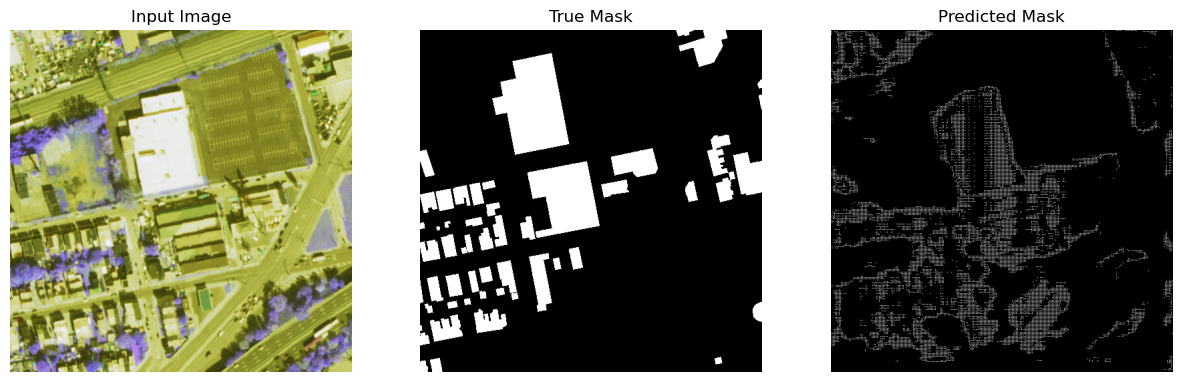

Average Accuracy: 0.8610


In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume the UNET class is already defined or imported from a relevant library
# from your_model_library import UNET

# Define the three functions from before
def batch_to_img(xb, idx):
    """
    Convert a single sample from a batch of data to a visualizable image format.

    Parameters:
    - xb (torch.Tensor): Input batch, shape (batch_size, channels, height, width)
    - idx (int): Index of the sample to convert

    Returns:
    - np.ndarray: Converted image, shape (height, width, channels)
    """
    img = xb[idx, 0:3].cpu().numpy()  # Extract the first 3 channels and move to CPU
    return np.transpose(img, (1, 2, 0))  # Rearrange the axes

def predb_to_mask(predb, idx):
    """
    Convert the model's prediction output into a class mask.

    Parameters:
    - predb (torch.Tensor): Model prediction output, shape (batch_size, num_classes, height, width)
    - idx (int): Index of the sample to process

    Returns:
    - torch.Tensor: Class mask, shape (height, width)
    """
    p = torch.functional.F.softmax(predb[idx], 1)  # Apply Softmax on the class dimension
    return p.argmax(0).cpu()  # Get the predicted class for each pixel and move to CPU

def acc_metric(predb, yb):
    """
    Calculate the accuracy of the model's predictions.

    Parameters:
    - predb (torch.Tensor): Model prediction output, shape (batch_size, num_classes, ...)
    - yb (torch.Tensor): True labels, shape (batch_size, ...)

    Returns:
    - torch.Tensor: Accuracy, scalar
    """
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

# Define the U-Net model and load pretrained weights
model = UNET(in_channels=3, out_channels=8)  # Adjust the input and output channels as needed
model_path = 'unet_build_model100epc_aug.pth'
model.load_state_dict(torch.load(model_path))
model.to('cuda:0')  # Move the model to GPU
model.eval()  # Switch to evaluation mode


# Define a function to visualize prediction results
def show_sample_prediction(xb, yb, pred_mask, idx=0):
    """
    Visualize the input image, true mask, and predicted mask.

    Parameters:
    - xb (torch.Tensor): Input batch, shape (batch_size, channels, height, width)
    - yb (torch.Tensor): True labels, shape (batch_size, height, width)
    - pred_mask (torch.Tensor): Predicted mask, shape (height, width)
    - idx (int): Index of the sample to visualize
    """
    # Convert input image to a visualizable format
    img = batch_to_img(xb, idx)

    # Get the true mask and predicted mask
    true_mask = yb[idx]
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Input image
    axs[0].imshow(img)
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    
    # True mask
    axs[1].imshow(true_mask.cpu().numpy(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[1].axis('off')
    
    # Predicted mask
    axs[2].imshow(pred_mask.numpy(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    
    plt.show()

# Get a batch of data and visualize predictions
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to('cuda:0')  # Move input images to GPU
        yb = yb.to('cuda:0')  # Move true masks to GPU
        
        output = model(xb)  # Make predictions
        
        # Print output type and stats
        print(output)
        print(f"Output Type and shape: {type(output), output.shape}")
        print(f"max value for output: {torch.max(output).item()}")
        """Output Type and shape: (<class 'torch.Tensor'>, torch.Size([5, 8, 512, 512]))
        max value for output: 10.288979530334473
        """
        # Get the predicted mask for the first sample
        pred_mask = predb_to_mask(output, idx=0)
        pred_mask = torch.where(pred_mask == 5, 1, 0)
        print(pred_mask)
        print(f"Max Value: {torch.max(pred_mask).item()}")
        print(f"Min Value: {torch.min(pred_mask).item()}")
        
        # Visualize the results for the first sample
        show_sample_prediction(xb, yb, pred_mask, idx=0)
        
        break  # Only show results for one batch


# Calculate the average accuracy on the entire test set
total_acc = 0.0
num_batches = 0

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to('cuda:0')
        yb = yb.to('cuda:0')
        
        output = model(xb)  # Make predictions
        acc = acc_metric(output, yb)  # Calculate accuracy for the current batch
        total_acc += acc.item()  # Accumulate accuracy
        num_batches += 1  # Count the number of batches

# Compute average accuracy
average_acc = total_acc / num_batches
print(f"Average Accuracy: {average_acc:.4f}")
